# 230968288 Dhanvithraj Shetty
Week 5 Q3/Q3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta


2025-08-25 16:10:44.026107: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 16:10:44.049934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 16:10:44.408596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


df = pd.read_csv("Burglary_Dataset.csv")

df['CrimeDate'] = pd.to_datetime(df['CrimeDate'], errors='coerce')

print(f"Dataset loaded: {df.shape[0]} records")
print(df.head())

Dataset loaded: 285807 records
   CrimeDate CrimeTime CrimeCode            Location           Description  \
0 2016-11-12  02:35:00        3B   300 SAINT PAUL PL      ROBBERY - STREET   
1 2016-11-12  02:56:00       3CF      800 S BROADWAY  ROBBERY - COMMERCIAL   
2 2016-11-12  03:00:00        6D    1500 PENTWOOD RD     LARCENY FROM AUTO   
3 2016-11-12  03:00:00        6D      6600 MILTON LN     LARCENY FROM AUTO   
4 2016-11-12  03:00:00        6E  300 W BALTIMORE ST               LARCENY   

  Inside/Outside   Weapon   Post      District                Neighborhood  \
0              O      NaN  111.0       CENTRAL                    Downtown   
1              I  FIREARM  213.0  SOUTHEASTERN                 Fells Point   
2              O      NaN  413.0  NORTHEASTERN  Stonewood-Pentwood-Winston   
3              O      NaN  424.0  NORTHEASTERN                   Westfield   
4              O      NaN  111.0       CENTRAL                    Downtown   

                        Locatio

In [3]:

df['CrimeCode'] = df['CrimeCode'].astype(str)

full_dates = pd.date_range(start='2014-01-01', end='2016-12-31')

larceny_df = df[df['CrimeCode'].str.startswith('6')]
larceny_daily = larceny_df.groupby('CrimeDate').size().reindex(full_dates, fill_value=0)

burglary_df = df[df['CrimeCode'].str.startswith('5')]
burglary_daily = burglary_df.groupby('CrimeDate').size().reindex(full_dates, fill_value=0)


In [4]:

def prepare_data(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 7

larceny_train = larceny_daily['2014-01-01':'2015-12-31'].values
larceny_test = larceny_daily['2016-01-01':'2016-12-31'].values
X_train_lar, y_train_lar = prepare_data(larceny_train, window_size)
X_test_lar, y_test_lar = prepare_data(larceny_test, window_size)

burglary_train = burglary_daily['2014-01-01':'2015-12-31'].values
burglary_test = burglary_daily['2016-01-01':'2016-12-31'].values
X_train_bur, y_train_bur = prepare_data(burglary_train, window_size)
X_test_bur, y_test_bur = prepare_data(burglary_test, window_size)

X_train_lar = X_train_lar[..., np.newaxis]
X_test_lar = X_test_lar[..., np.newaxis]
X_train_bur = X_train_bur[..., np.newaxis]
X_test_bur = X_test_bur[..., np.newaxis]


In [5]:

def build_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(SimpleRNN(64))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model



In [6]:
rnn_lar_model = build_rnn((window_size, 1))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

rnn_lar_history = rnn_lar_model.fit(X_train_lar, y_train_lar,
                                    validation_split=0.2,
                                    epochs=50,
                                    batch_size=32,
                                    callbacks=[early_stop],
                                    verbose=1)


2025-08-25 16:10:59.277772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-25 16:10:59.292227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-25 16:10:59.292345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2025-08-25 16:11:01.324809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-25 16:11:01.329933: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20d807c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-25 16:11:01.329947: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-08-25 16:11:01.333023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-25 16:11:01.418995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-08-25 16:11:01.474699: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

19/19 [==============================] - 3s 18ms/step - loss: 729.0278 - val_loss: 562.9968
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 588.1845 - val_loss: 519.7513
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 540.6994 - val_loss: 469.8722
Epoch 4/50
19/19 [==============================] - 0s 8ms/step - loss: 502.8328 - val_loss: 439.2536
Epoch 5/50
19/19 [==============================] - 0s 8ms/step - loss: 474.2083 - val_loss: 416.5674
Epoch 6/50
19/19 [==============================] - 0s 8ms/step - loss: 450.6848 - val_loss: 392.5320
Epoch 7/50
19/19 [==============================] - 0s 8ms/step - loss: 431.2798 - val_loss: 378.6591
Epoch 8/50
19/19 [==============================] - 0s 9ms/step - loss: 408.7702 - val_loss: 353.9137
Epoch 9/50
19/19 [==============================] - 0s 8ms/step - loss: 388.6653 - val_loss: 337.2570
Epoch 10/50
19/19 [==============================] - 0s 9ms/step - loss: 370.5035 - val_loss

In [7]:
#train models for Burglary

rnn_bur_model = build_rnn((window_size, 1))


rnn_bur_history = rnn_bur_model.fit(X_train_bur, y_train_bur,
                                    validation_split=0.2,
                                    epochs=50,
                                    batch_size=32,
                                    callbacks=[early_stop],
                                    verbose=1)


Epoch 1/50
19/19 [==============================] - 2s 22ms/step - loss: 97.0506 - val_loss: 93.4040
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 60.2673 - val_loss: 73.5787
Epoch 3/50
19/19 [==============================] - 0s 9ms/step - loss: 48.9526 - val_loss: 64.8481
Epoch 4/50
19/19 [==============================] - 0s 8ms/step - loss: 43.8851 - val_loss: 58.1260
Epoch 5/50
19/19 [==============================] - 0s 8ms/step - loss: 41.6073 - val_loss: 56.1192
Epoch 6/50
19/19 [==============================] - 0s 9ms/step - loss: 39.7263 - val_loss: 52.7853
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 38.9340 - val_loss: 51.2308
Epoch 8/50
19/19 [==============================] - 0s 8ms/step - loss: 38.0065 - val_loss: 50.4044
Epoch 9/50
19/19 [==============================] - 0s 9ms/step - loss: 37.3782 - val_loss: 49.0083
Epoch 10/50
19/19 [==============================] - 0s 9ms/step - loss: 38.0269 - val_loss: 48.709

12/12 [==============================] - 0s 3ms/step
Larceny - Simple RNN MAPE: 14181504007852090.0000, RMSE: 11.85


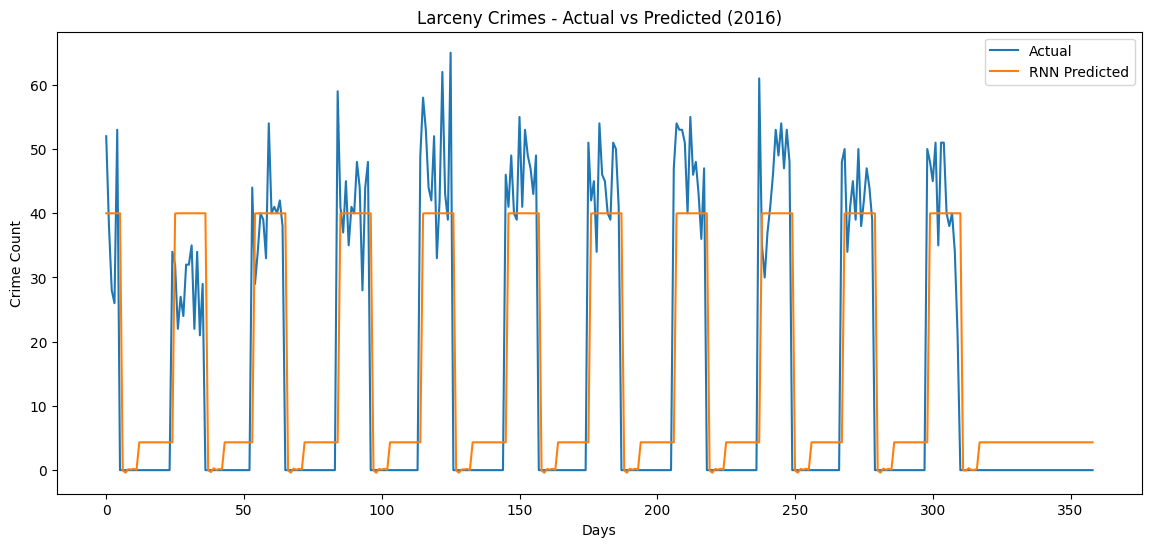

In [8]:
#Evaluate models (Larceny)

rnn_lar_pred = rnn_lar_model.predict(X_test_lar).flatten()

rnn_mape_lar = mean_absolute_percentage_error(y_test_lar, rnn_lar_pred)
rnn_rmse_lar = np.sqrt(mean_squared_error(y_test_lar, rnn_lar_pred))

print(f"Larceny - Simple RNN MAPE: {rnn_mape_lar:.4f}, RMSE: {rnn_rmse_lar:.2f}")

plt.figure(figsize=(14,6))
plt.plot(y_test_lar, label='Actual')
plt.plot(rnn_lar_pred, label='RNN Predicted')
plt.title('Larceny Crimes - Actual vs Predicted (2016)')
plt.xlabel('Days')
plt.ylabel('Crime Count')
plt.legend()
plt.show()


12/12 [==============================] - 0s 2ms/step
Burglary - Simple RNN MAPE: 5471056594631700.0000, RMSE: 8.74


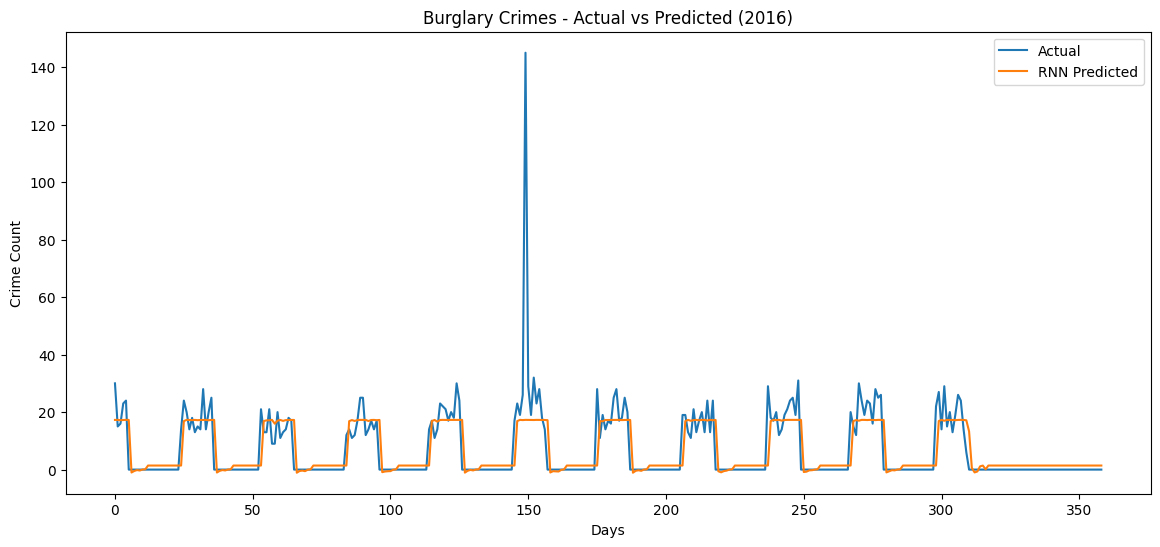

In [9]:
# Evaluate models (Burglary)

rnn_bur_pred = rnn_bur_model.predict(X_test_bur).flatten()

rnn_mape_bur = mean_absolute_percentage_error(y_test_bur, rnn_bur_pred)
rnn_rmse_bur = np.sqrt(mean_squared_error(y_test_bur, rnn_bur_pred))

print(f"Burglary - Simple RNN MAPE: {rnn_mape_bur:.4f}, RMSE: {rnn_rmse_bur:.2f}")


plt.figure(figsize=(14,6))
plt.plot(y_test_bur, label='Actual')
plt.plot(rnn_bur_pred, label='RNN Predicted')
plt.title('Burglary Crimes - Actual vs Predicted (2016)')
plt.xlabel('Days')
plt.ylabel('Crime Count')
plt.legend()
plt.show()
